# Exploratory Time Series Analysis — Monthly Revenue

This notebook explores the temporal structure of monthly revenue, focusing on:
- Trend
- Seasonality
- Variability
- Structural patterns relevant for forecasting

The goal is to inform model selection and forecasting strategy.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [5]:

df = pd.read_excel(
    "online_retail_raw.xlsx",
    parse_dates=["InvoiceDate"]
)

df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [7]:
# Create Revenue column
df["Revenue"] = df["Quantity"] * df["UnitPrice"]

# Remove cancelled / negative invoices (important for forecasting)
df = df[df["Revenue"] > 0]

# Aggregate to monthly revenue
monthly_revenue = (
    df
    .set_index("InvoiceDate")
    .resample("M")["Revenue"]
    .sum()
    .to_frame(name="MonthlyRevenue")
)

monthly_revenue.head()


/tmp/ipython-input-605885552.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")["Revenue"]


,MonthlyRevenue
InvoiceDate,
2010-12-31,823746.140
2011-01-31,691364.560
2011-02-28,523631.890
2011-03-31,717639.360
2011-04-30,537808.621


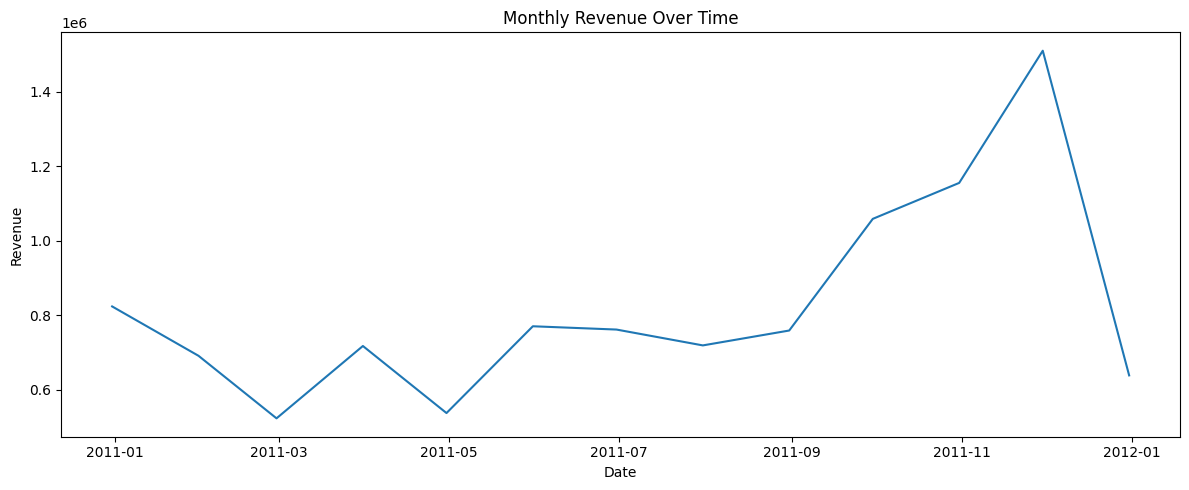

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(monthly_revenue.index, monthly_revenue["MonthlyRevenue"])
plt.title("Monthly Revenue Over Time")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.tight_layout()
plt.show()


In [10]:
monthly_revenue.to_csv("monthly_revenue.csv")



#Rolling Statistics (Trend & Variance Stability)

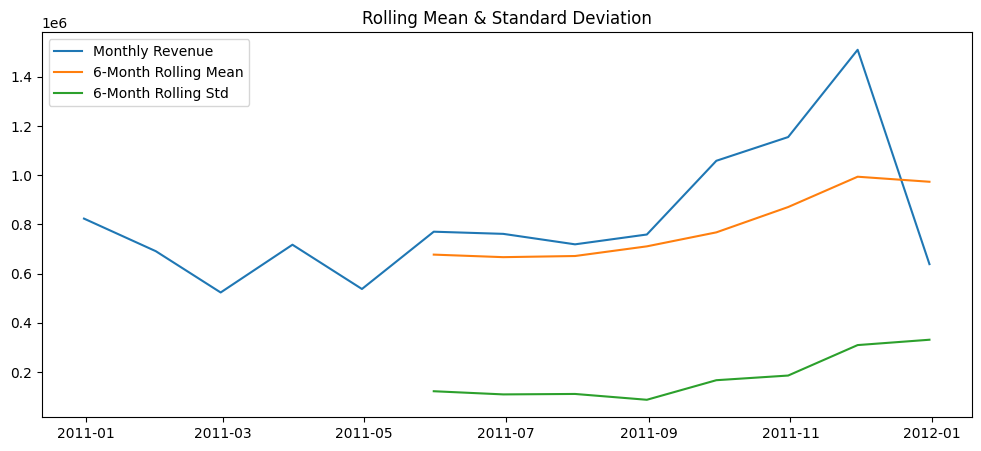

In [11]:
rolling_mean = monthly_revenue["MonthlyRevenue"].rolling(window=6).mean()
rolling_std = monthly_revenue["MonthlyRevenue"].rolling(window=6).std()

plt.figure(figsize=(12,5))
plt.plot(monthly_revenue, label="Monthly Revenue")
plt.plot(rolling_mean, label="6-Month Rolling Mean")
plt.plot(rolling_std, label="6-Month Rolling Std")
plt.legend()
plt.title("Rolling Mean & Standard Deviation")
plt.show()


#Step 1 — Build daily revenue series

In [15]:
daily_revenue = (
    df.set_index("InvoiceDate")["Revenue"]
      .resample("D").sum()
      .asfreq("D")
)

daily_revenue.head()

,Revenue
InvoiceDate,
2010-12-01,58960.79
2010-12-02,47748.38
2010-12-03,46943.71
2010-12-04,0.00
2010-12-05,31774.95


#Step 2 — Seasonal decomposition (weekly)

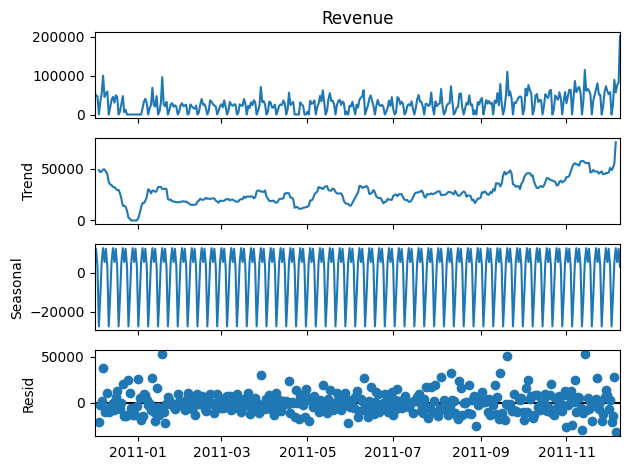

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(daily_revenue, model="additive", period=7)
decomp.plot()
plt.show()



#Step 3: Baseline Forecast (Train/Test Split)

#Step 3.1 — Create forecasting series (daily)

In [17]:
daily_revenue = (
    df.set_index("InvoiceDate")["Revenue"]
      .resample("D").sum()
      .asfreq("D")
)


In [19]:
daily_revenue = daily_revenue.fillna(0)


#Step 3.2 — Train / Test split (last 60 days as test)

In [20]:
train = daily_revenue[:-60]
test  = daily_revenue[-60:]

train.shape, test.shape


((314,), (60,))

In [21]:
naive_forecast = test.copy()
naive_forecast[:] = train.iloc[-1]


#Step 3.3 — Baseline forecast (Naive / Last Value)

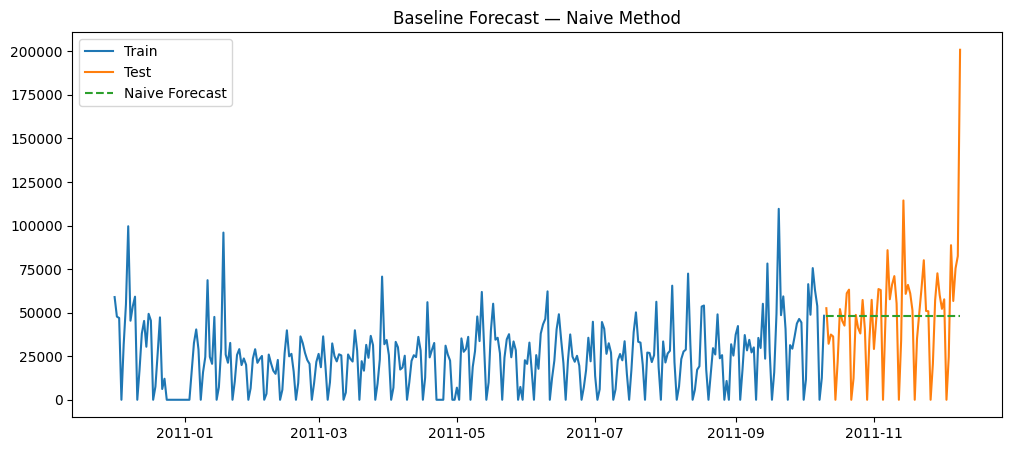

In [22]:
plt.figure(figsize=(12,5))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test")
plt.plot(test.index, naive_forecast, label="Naive Forecast", linestyle="--")
plt.legend()
plt.title("Baseline Forecast — Naive Method")
plt.show()


#Step 3.4 — Evaluate error (MAE & RMSE)

In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae  = mean_absolute_error(test, naive_forecast)
rmse = np.sqrt(mean_squared_error(test, naive_forecast))

mae, rmse


(21789.210499999997, np.float64(31948.37892726596))